TensorFlow version: 2.9.1
Epoch 1/3
1407/1407 [==============================] - 71s 46ms/step - loss: 1.3322 - accuracy: 0.5371 - val_loss: 1.1555 - val_accuracy: 0.5938
Epoch 2/3
1407/1407 [==============================] - 64s 45ms/step - loss: 1.1085 - accuracy: 0.6142 - val_loss: 1.1210 - val_accuracy: 0.6098
Epoch 3/3
1407/1407 [==============================] - 64s 46ms/step - loss: 1.0692 - accuracy: 0.6263 - val_loss: 1.1234 - val_accuracy: 0.6078
Epoch 1/3
1407/1407 [==============================] - 100s 66ms/step - loss: 2.3353 - accuracy: 0.0991 - val_loss: 2.3525 - val_accuracy: 0.0986
Epoch 2/3
1407/1407 [==============================] - 93s 66ms/step - loss: 2.3344 - accuracy: 0.1008 - val_loss: 2.4092 - val_accuracy: 0.1038
Epoch 3/3
313/313 [==============================] - 20s 57ms/step
Accuracy: 0.620, F1: 0.617, Precision: 0.627, Recall: 0.620


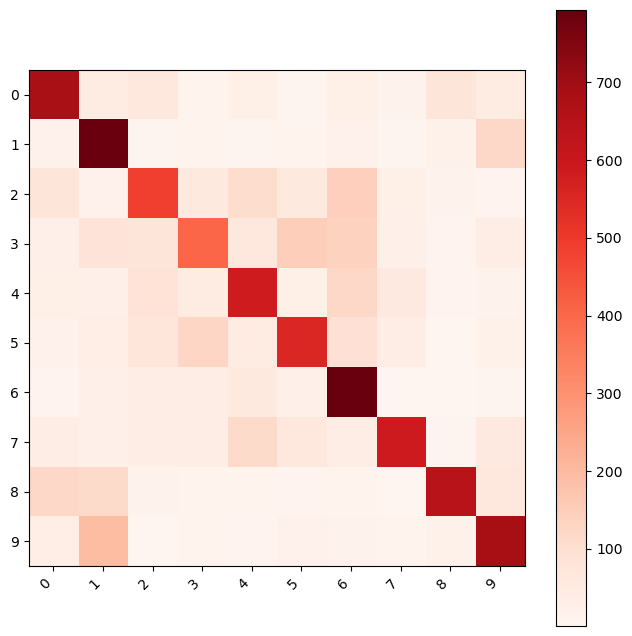

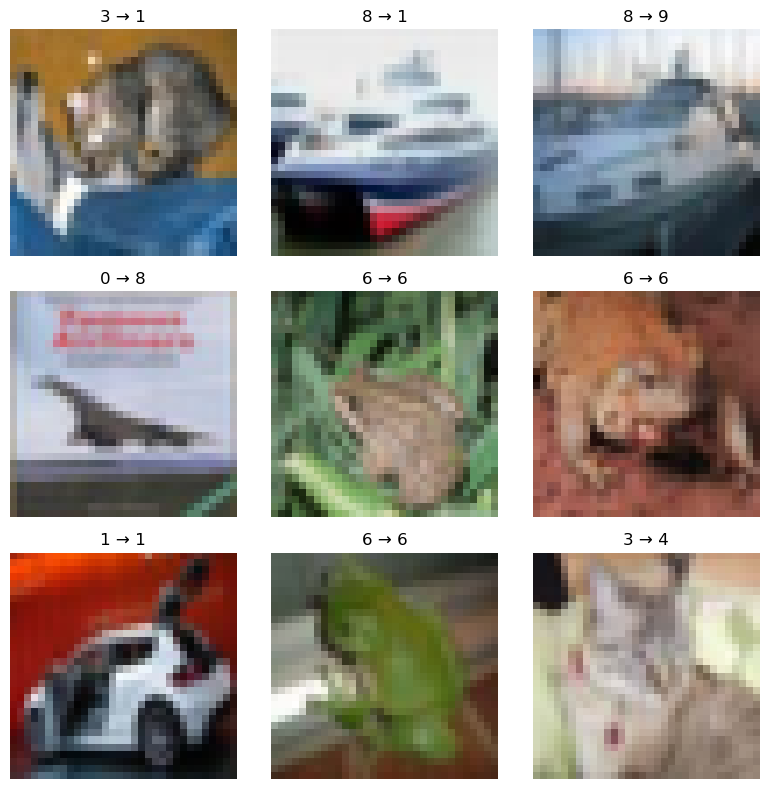

In [4]:
# Only top layers of large models are trained → fast.
# Demonstrates ensembling two pretrained models.

# -----------------------------
# 1. Imports & Setup
# -----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
print("TensorFlow version:", tf.__version__)

# Enable memory growth on GPU (optional)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# -----------------------------
# 2. Dataset (CIFAR-10 for demo)
# -----------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# Normalize images
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Quick train/validation split
val_split = 5000
x_val, y_val = x_train[-val_split:], y_train[-val_split:]
x_train, y_train = x_train[:-val_split], y_train[:-val_split]

BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2000).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# -----------------------------
# 3. Helper Functions
# -----------------------------
def plot_images(images, labels, preds=None, class_names=None, n=9):
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        title = class_names[labels[i]] if class_names else labels[i]
        if preds is not None:
            title += f" → {class_names[preds[i]]}" if class_names else f" → {preds[i]}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def compute_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {np.mean(y_true==y_pred):.3f}, F1: {f1:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
    cmat = confusion_matrix(y_true, y_pred)
    return cmat

def plot_confusion_matrix(cmat, class_names):
    plt.figure(figsize=(8,8))
    plt.imshow(cmat, cmap='Reds')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar()
    plt.show()

class_names = [str(i) for i in range(10)]  # CIFAR-10 labels

# -----------------------------
# 4. Model Creation (Frozen Base)
# -----------------------------
def create_model(base_model_class, input_shape=(32,32,3), num_classes=10):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs) if base_model_class != tf.keras.applications.DenseNet121 else inputs
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create 2 models
model1 = create_model(tf.keras.applications.DenseNet121)
model2 = create_model(tf.keras.applications.EfficientNetB0)

# -----------------------------
# 5. Training (top layers only)
# -----------------------------
EPOCHS = 3  # small for demo
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# -----------------------------
# 6. Ensemble Inference
# -----------------------------
# Predict probabilities
probs1 = model1.predict(test_ds)
probs2 = model2.predict(test_ds)

# Average logits (before softmax)
logits1 = np.log(np.clip(probs1, 1e-7, 1-1e-7))
logits2 = np.log(np.clip(probs2, 1e-7, 1-1e-7))
ensemble_logits = (logits1 + logits2) / 2
ensemble_preds = np.argmax(tf.nn.softmax(ensemble_logits), axis=1)

# -----------------------------
# 7. Evaluation
# -----------------------------
y_test_flat = y_test
cmat = compute_metrics(y_test_flat, ensemble_preds)
plot_confusion_matrix(cmat, class_names)

# -----------------------------
# 8. Example Predictions
# -----------------------------
sample_images = x_test[:9]
sample_labels = y_test_flat[:9]
sample_preds = ensemble_preds[:9]
plot_images(sample_images, sample_labels, sample_preds, class_names)


TensorFlow version: 2.9.1
Epoch 1/3
64/64 [==============================] - 51s 692ms/step - loss: 4.6344 - accuracy: 0.0569 - val_loss: 3.5512 - val_accuracy: 0.2206
Epoch 2/3
64/64 [==============================] - 48s 751ms/step - loss: 2.7811 - accuracy: 0.4618 - val_loss: 2.5587 - val_accuracy: 0.4961
Epoch 3/3
64/64 [==============================] - 49s 775ms/step - loss: 1.8054 - accuracy: 0.7490 - val_loss: 2.0080 - val_accuracy: 0.6275
Epoch 1/3
64/64 [==============================] - 30s 365ms/step - loss: 4.8695 - accuracy: 0.0020 - val_loss: 4.6833 - val_accuracy: 0.0098
Epoch 2/3
64/64 [==============================] - 23s 363ms/step - loss: 4.7723 - accuracy: 0.0059 - val_loss: 4.6886 - val_accuracy: 0.0098
Epoch 3/3
385/385 [==============================] - 61s 155ms/step


C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.569, F1: 0.559, Precision: 0.675, Recall: 0.600


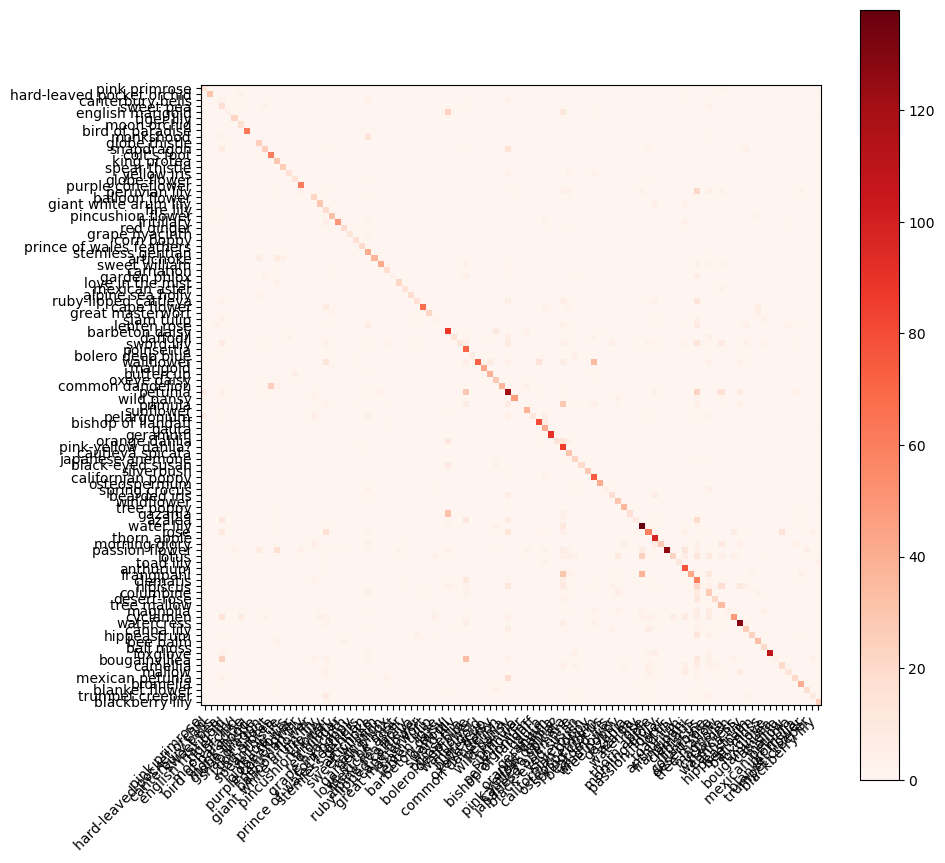

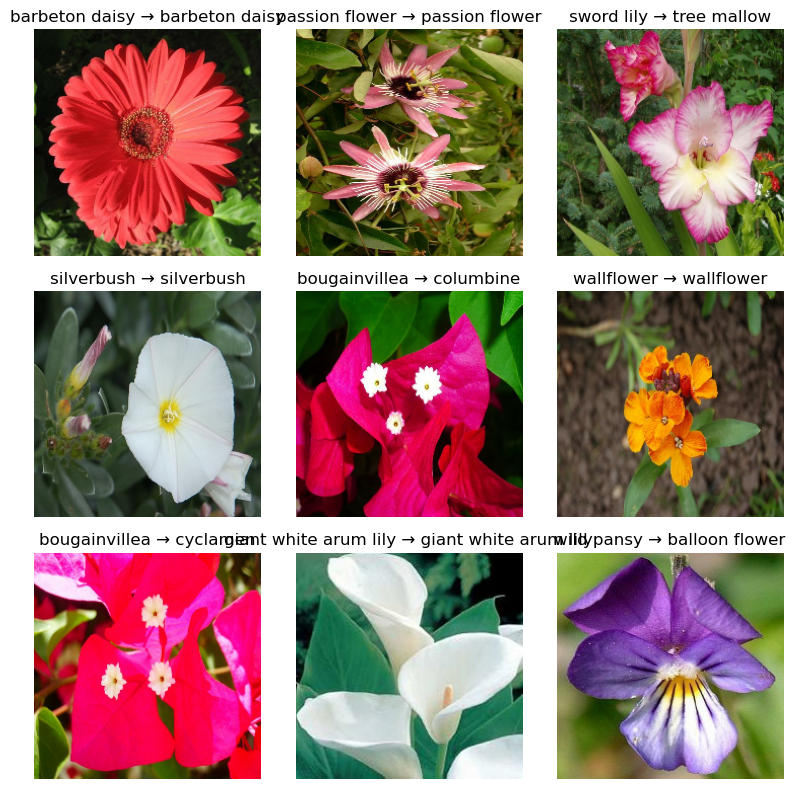

In [6]:
# Using TFDS
# Two models are trained only on top layers for speed.
# Ensemble via logit averaging.
# Easy to extend: just swap DenseNet121 or EfficientNetB0 for bigger models.

# ===========================
# 1. Imports & Setup
# ===========================
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

print("TensorFlow version:", tf.__version__)

# Optional GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

AUTO = tf.data.AUTOTUNE

# ===========================
# 2. Load TFDS Flowers102
# ===========================
ds, info = tfds.load('oxford_flowers102', split=['train', 'validation', 'test'], as_supervised=True, with_info=True)
train_ds, val_ds, test_ds = ds

NUM_CLASSES = info.features['label'].num_classes
class_names = info.features['label'].names
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16

# ===========================
# 3. Preprocessing
# ===========================
def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTO).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTO)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

# ===========================
# 4. Helper Functions
# ===========================
def compute_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    acc = np.mean(y_true==y_pred)
    print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
    cmat = confusion_matrix(y_true, y_pred)
    return cmat

def plot_confusion_matrix(cmat, class_names):
    plt.figure(figsize=(10,10))
    plt.imshow(cmat, cmap='Reds')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar()
    plt.show()

def dataset_to_numpy(dataset):
    images, labels = [], []
    for x, y in dataset:
        images.append(x)
        labels.append(y)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

# ===========================
# 5. Model Creation
# ===========================
def create_model(base_model_class, input_shape=(224,224,3), num_classes=NUM_CLASSES, fine_tune=False):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = fine_tune
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create two lightweight models
model1 = create_model(tf.keras.applications.DenseNet121)
model2 = create_model(tf.keras.applications.EfficientNetB0)

# ===========================
# 6. Training (top layers only)
# ===========================
EPOCHS = 3  # demo only
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ===========================
# 7. Ensemble Inference
# ===========================
x_test_np, y_test_np = dataset_to_numpy(test_ds)

probs1 = model1.predict(test_ds)
probs2 = model2.predict(test_ds)

# Option 1: ensemble via logit averaging
logits1 = np.log(np.clip(probs1, 1e-7, 1-1e-7))
logits2 = np.log(np.clip(probs2, 1e-7, 1-1e-7))
ensemble_logits = (logits1 + logits2)/2
ensemble_preds = np.argmax(tf.nn.softmax(ensemble_logits), axis=1)

# ===========================
# 8. Evaluation
# ===========================
cmat = compute_metrics(y_test_np, ensemble_preds)
plot_confusion_matrix(cmat, class_names)

# ===========================
# 9. Show Example Predictions
# ===========================
def plot_images(images, labels, preds=None, class_names=None, n=9):
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        title = class_names[labels[i]] if class_names else labels[i]
        if preds is not None:
            title += f" → {class_names[preds[i]]}" if class_names else f" → {preds[i]}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(x_test_np[:9], y_test_np[:9], ensemble_preds[:9], class_names)
